<a href="https://colab.research.google.com/github/abelowska/mlNeuro/blob/main/MLN_basic_mne_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic MNE tutorial

[`MNE`](https://mne.tools/stable/index.html) is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more.

The easiest way is to install MNE via Anaconda, `pip`, or `conda` (see [installation instructions](https://mne.tools/stable/install/manual_install.html)).

In [ ]:
!pip install mne

Imports

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd

## Raw

We are going to use data from the [ERP CORE Dataset](https://doi.org/10.1016/j.neuroimage.2020.117465). This dataset contains EEG recordings from a single participant performing Flanker task.

In [ ]:
data_dir = Path(mne.datasets.erp_core.data_path('.'))
file_name = data_dir / "ERP-CORE_Subject-001_Task-Flankers_eeg.fif"

**MNE**-Python data structures are based around the FIF file format from Neuromag, but there are reader functions for a wide [variety of other data formats](https://mne.tools/stable/overview/implementation.html#data-formats). Data is loaded into so-called [Raw](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw) object.


In [ ]:
raw = mne.io.read_raw(file_name, preload=True)

You can get a glimpse of the basic details of a Raw object by printing it; even more is available by printing its `info` attribute (a dictionary-like object that is preserved across Raw, Epochs, and Evoked objects). The `info` data structure keeps track of channel locations, applied filters, projectors, etc. Notice especially the chs entry, showing that MNE-Python detects different sensor types and handles each appropriately. See The Info data structure for more on the [`Info`](https://mne.tools/stable/generated/mne.Info.html) class.

In [ ]:
raw.info

In [ ]:
print(raw.info)

Let's see our EEG data. Basic MNE classes ([`Raw`](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw), [`Epochs`](https://mne.tools/stable/generated/mne.Epochs.html), [`Evoked`](https://mne.tools/stable/generated/mne.Evoked.html)) have special method for plotting. Just call method `plot()` on the `Raw` object to see the data.

In [ ]:
fig = raw.plot()

It doesn't look pretty, does it? It's because EEG data is contaminated with the high frequencies.

Take a look into the documentation of [`plot()`](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.plot) and plot our data with low- and high-pass filters and from the 60th second. It should look like this:

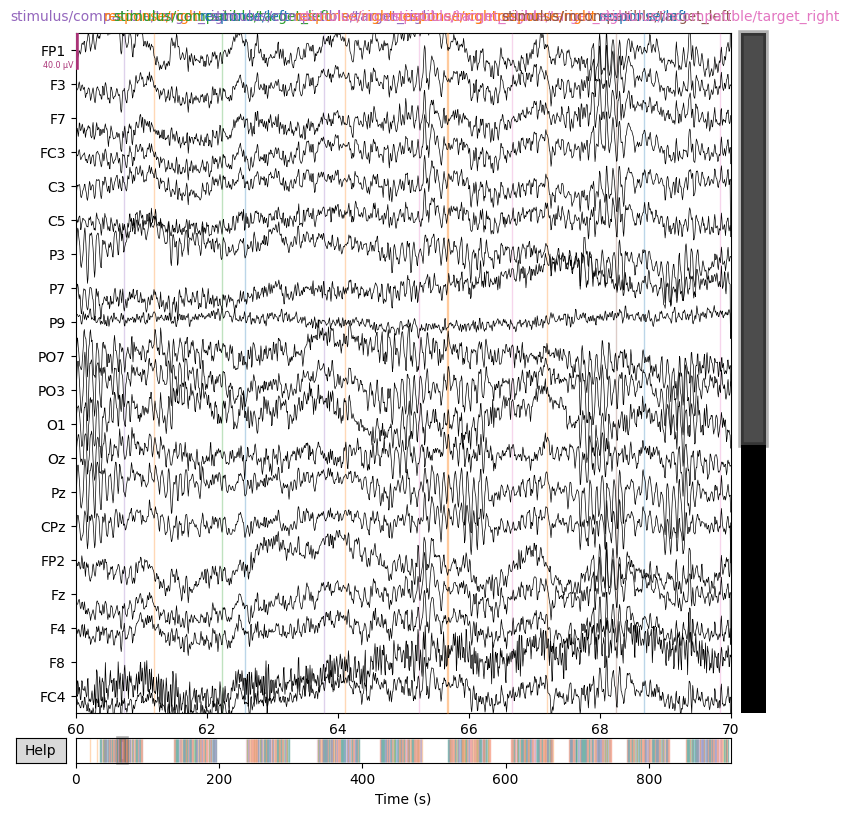

In [ ]:
fig = raw.plot() # TODO

On the plot, we can see the triggers (events) marked with vertical colored lines.

**Annotations**

[Annotations](https://mne.tools/stable/generated/mne.Annotations.html) in MNE-Python store short strings of information about temporal spans of a Raw object. Below the surface, Annotations are list-like objects, where each element comprises three pieces of information: an onset time (in seconds), a duration (also in seconds), and a description (a text string). Additionally, the Annotations object itself also keeps track of orig_time, which is a POSIX timestamp denoting a real-world time relative to which the annotation onsets should be interpreted. In general, annotations store information about [Events](https://mne.tools/dev/events.html#events) that occurred and were encoded during EEG recording. Such events could be a keystroke, the appearance of a target, feedback, etc.

In our case, we have information on responses and stimulus.

In [ ]:
# extract events
events, event_ids = mne.events_from_annotations(raw)

In [ ]:
# display events names
event_ids

Event ids are defined as a dictionary of names and their codes, as we can see above.

The resulting events array is an ordinary 3-column `ndarray`, with sample number in the first column and integer event ID in the last column; the middle column is usually ignored.

In [ ]:
# display events
events

On the plot below we can see stimulus and response events marked with coloured vertical lines and EEG signal on 32 electrodes.

In [ ]:
fig = raw.plot(
    start=60.5,
    duration=1,
    highpass=0.05,
    lowpass=40,
    n_channels=32,
    show=False
)

plt.show()

`Raw` class has a lot of useful method. Eee examples below and look at the documentation.

In [ ]:
# plot sensors
fig = raw.plot_sensors(show_names=True)

In [ ]:
# dump raw data to dataframe
raw_df = raw.to_data_frame()
raw_df.head()

In [ ]:
# filter raw data
fig = raw.plot()

raw.filter(l_freq=0.1, h_freq=40)

fig = raw.plot()

Keep in mind that MNE methods work in place – MNE objects are mutable, and by default, operations are always performed in place, modifying your object. To keep your original object, always work on copies, e.g.

```
raw_filtered = raw.copy()
raw_filtered.filter(l_freq=0.1, h_freq=40)
```

## Epochs

The Raw object and the events array are the bare minimum needed to create an [`Epochs`](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) object, which we create with the `Epochs` class constructor.

Basically, `Epochs` store single-trial event-related potentials (ERPs), thus they have to be constructed **around some defined events**.

To do so, we **have to**:
- pass the event dictionary as the `event_ids` parameter;
- pass the list of events;
- specify tmin and tmax (the time relative to each event at which to start and end each epoch).

By default Raw and Epochs data aren’t loaded into memory (they’re accessed from disk only when needed), but here we’ll force loading into memory using the `preload=True`.

Now, we are going to create an epoch around every event that is in our `Raw`.

In [ ]:
tmin=-0.1
tmax=0.8

events, event_ids = mne.events_from_annotations(raw)

epochs = mne.Epochs(
  raw=raw,
  events=events,
  event_id=event_ids,
  tmin=tmin,
  tmax=tmax,
  baseline=(-0.1, 0),
  reject_by_annotation=True,
  preload=True,
)

Again, we can print the basic details of `Epochs` object.

In [ ]:
epochs

In [ ]:
epochs.info

Like `Raw`, `Epochs` also have a number of built-in plotting methods. One is [`plot_image()`](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.plot_image), which shows each epoch as one row of an image map, with color representing signal magnitude; the average evoked response and the sensor location are shown below the image:

In [ ]:
fig = epochs.plot_image(picks=['FCz'])

In [ ]:
fig = epochs.plot(events=events)

## Evoked

MNE-Python has a special object for averaged signal called [`Evoked`](https://mne.tools/stable/generated/mne.Evoked.html#mne-evoked). `Evoked` objects typically store EEG or MEG signals that have been averaged over multiple epochs, which is a common technique for estimating stimulus-evoked activity (ERPs). Evoked objects can only contain the average of a single set of conditions. Evoked might created by calling `.average()` method on Epoch object.

The data in an Evoked object are stored in an array of shape (`n_channels, n_times)` (in contrast to an Epochs object, which stores data of shape`(n_epochs, n_channels, n_times)`).

The simplest way to create `Evoked` is to call `average()` method on `Epochs` ocject. The `Evoked` is a classic ERP wave.

In [ ]:
# create evokeds
left_congruent_epochs = epochs['stimulus/compatible/target_left'].average()
left_incongruent_epochs = epochs['stimulus/incompatible/target_left'].average()

Let's see the info about the created object:

In [ ]:
left_congruent_epochs

The information about the signal in `Epochs` is transferred to derived `Evoked` objects:

In [ ]:
left_congruent_epochs.info

We can plot the `Evoked`s using default method for plotting.

In [ ]:
fig = left_congruent_epochs.plot(spatial_colors=True)
fig = left_incongruent_epochs.plot(spatial_colors=True)

There are many built-in plotting methods that allow us to explore our data.

In [ ]:
fig = left_congruent_epochs.plot_joint(times=[-0.1, 0.1, 0.2, 0.3, 0.4])
fig = left_incongruent_epochs.plot_joint(times=[-0.1, 0.1, 0.2, 0.3, 0.4])

We can use specific MNE method for visualization [`mne.viz.plot_compare_evokeds()`](https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html#mne-viz-plot-compare-evokeds) to directly compare our two types of events: congruent-left and incongruent-left:  

In [ ]:
# compare congruent and incongruent ERPs
evokeds_left = dict(congruent_left=left_congruent_epochs, incongruent_left=left_incongruent_epochs)
picks = ['FCz']

fig = mne.viz.plot_compare_evokeds(
    evokeds = evokeds_left,
    picks=picks,
)

As with `Raw` and `Epochs` objects, `Evoked` gives a lot of opportunities to work on the signal. For an examples of manipulating and working with Evoked, see the [tutorial](https://mne.tools/stable/auto_tutorials/evoked/10_evoked_overview.html#sphx-glr-auto-tutorials-evoked-10-evoked-overview-py).

## Exercises

### Raw

**Exercise 1**: Selecting and dropping channels for.

Altering the channels of a Raw object can be done in several ways. Try to use the [`pick()`](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.pick) method to restrict the Raw object to just the EEG channels.

In [ ]:
# always work on the copy of the original data
raw_copy = raw.copy()

# your code here

**Exercise 2**: Selecting data in the time domain.

If you want to limit the time domain of a `Raw` object, you can use the [`crop()`](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.crop) method. Limit your `Raw` to time-window 1min - 10min.

In [ ]:
# always work on the copy of the original data
print(raw.times.min(), raw.times.max())
raw_copy = raw.copy()

# your code here
print(raw_copy.times.min(), raw_copy.times.max())

**Exercise 3**: Extracting data from `Raw` objects.

There are multiple ways of extracting data from a `Raw` object into a NumPy array.

**3.1** To select portions of the data, `Raw` objects can be indexed using square brackets, where the first dimention are *channels*, and the second *timepoints*. Along with the requested sample value(s) `MNE-Python` also returns an array of times (in seconds) corresponding to the requested samples. The data array and the times array are returned together as elements of a tuple.

Try to select data from 1st to 2nd minute on FCz channel. Mind, that when extracting data with slicing, you need to provide *timepoints*, not *seconds*. Use the sampling frequency to find correct indexes.

In [ ]:
sampling_freq = raw.info["sfreq"]
start_stop_seconds = # TODO
start_sample, stop_sample = # TODO

channel_index = # find which index has FCz in raw.info.ch_names list
raw_selection_data, raw_selection_times = # TODO

print(raw_selection_times)

**3.2** `Raw.get_data()` method.

If you only want the data, `Raw` objects have a [`get_data()`](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.get_data) method. It returns data as (n_channels, n_timepoints) NumPy array.

Use `get_data()` method to extract exactly the same data as in previous exercise. Plot both arrays to make sure you have indeed extracted the same slice of data.

In [ ]:
# your code here

For overview of methods for extracting data from `Raw` object, see: [documentation](https://mne.tools/stable/auto_tutorials/raw/10_raw_overview.html#summary-of-ways-to-extract-data-from-raw-objects).

### Epochs

**Exercise 4**: Usually we want to have epochs with only one type of single-trials, e.g., stimulus-locked, or response-locked.

Create epochs in such a way as to have only stimuli-locked epochs. Look into the documentation of [`Epochs`](https://mne.tools/stable/generated/mne.Epochs.html) constructor and find which parameter defines the events of interest.

In [ ]:
tmin=-0.1
tmax=0.8

events, event_ids = mne.events_from_annotations(raw)

epochs = # TODO

epochs

**Exercise 5**: For now, we are not interested in left/right differentiation, only congruent/incongruent. Try to create epochs that contains only congruent vs incongruent epochs. Use [`merge_events()`](https://mne.tools/stable/generated/mne.merge_events.html#mne.merge_events) method to merge events twice: once congruent, and one incongruent; and then build `Epochs` based on new events array.

In [ ]:
# your code here

**Alternative way**: You can also familiarize with [this tutorial](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html#tut-section-subselect-epochs) to understand how to properly pool trial types to analyses, when events are constructed with '\\'.

**Exercise 6**: Spectral analysis.

We want to compare power of brain bands of congruent vs incongruent trials, to see if there is any difference in any power band. To do so, we can use [`compute_psd()`](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.compute_psd) method to create the spectral representation of each epoch.

**6.1** Using `compute_psd()` metod, create `epochs_spectrum` variable that contains spectral representation of our epochs with the lower-bound of frequencies set on 1Hz and the upper-bound set on 100 Hz. Mind, that `compute_psd()` returns [`EpochsSpectrum`](https://mne.tools/stable/generated/mne.time_frequency.EpochsSpectrum.html#mne.time_frequency.EpochsSpectrum) object. Plot the results using default [`plot()`](https://mne.tools/stable/generated/mne.time_frequency.EpochsSpectrum.html#mne.time_frequency.EpochsSpectrum.plot) method for `EpochsSpectrum`.

**Why there is so big drop in power of frequencies above 40 Hz?**

In [ ]:
epochs_spectrum = # TODO

**6.2** Now, when you have `EpochsSpectrum`, you can use [`plot_topomap()`](https://mne.tools/stable/generated/mne.time_frequency.EpochsSpectrum.html#mne.time_frequency.EpochsSpectrum.plot_topomap) method to plot brain bands. The plots should looks like this:

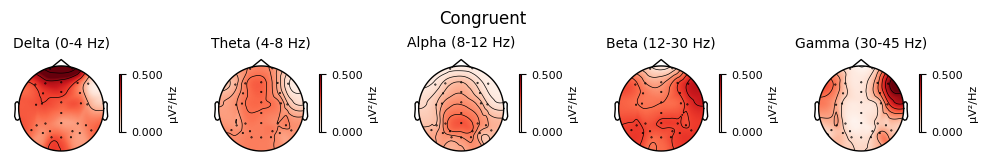

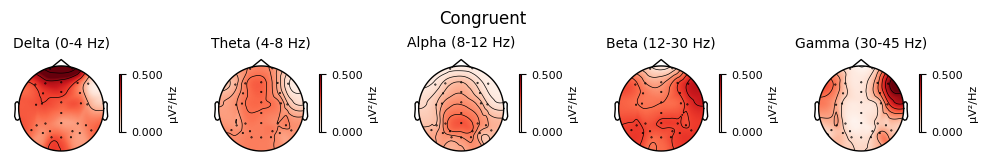

In [ ]:
# your code here

MNE-Python offers a huge number of tools for working on EEG signals. It also has great [tutorials](https://mne.tools/stable/auto_tutorials/index.html) and [examples](https://mne.tools/stable/auto_examples/index.html). I strongly encourage you to familiarize yourself with them.